In [2]:
import torch
import torchaudio
torchaudio.set_audio_backend("sox_io") #If i didn't add this part it would send me a warnitng that i needed it
from matplotlib import pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader

torch.Size([1, 201, 17159])


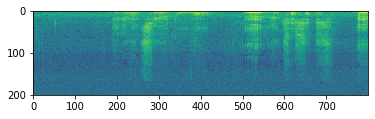

In [31]:
path='sacco/audio_24@10-01-2020_18-39-11.ogg'
audio_signal,sample_rate=torchaudio.load(path)
Spectrogram=torchaudio.transforms.Spectrogram() #Define the function of the spectogram
spectrogram=Spectrogram(audio_signal) #calculate the spectogram
plt.imshow(spectrogram.log2()[0,:,800:1600]) #To see the images you have to use the log2
print(spectrogram.size())
plt.show()


# Data loader

In [32]:
#Do i have to add cuda here?
class Data(Dataset):
    def __init__(self,people,audio=None,authors=None,Transform=torchaudio.transforms.Spectrogram()):
        if audio==None: self.audio=[]
        else: self.audio=audio
        if authors==None: self.authors=[]
        else: self.authors=authors
        self.people=people          
        self.Transform=Transform
        
        
    
    def __len__(self):
        return len(self.audio)
    
    #Does not work if you call Data[x:y]    
    def __getitem__(self,index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        audio_files=self.audio[index]
        authors=self.authors[index]
        if (isinstance(audio_files, str)):  
            audio,sample_rate=torchaudio.load(audio_files)
            audio=self.Transform(audio)
            return audio,authors 
        
        # If audio is a list we have to process each element individually
        # This code is called if we want a slice of elements ex: [5:7]
        audios = []
        samplerates = []
        for audio_file in audio_files:
            audio,samplerate=torchaudio.load(audio_file)
            audio=self.Transform(audio)
            audios.append(audio)
            samplerates.append(samplerate)
            
        return audios, samplerates
        
        
        
    
    def append(audio,authors): #doesn't work
        self.audio.append(audio)
        self.authors.append(authors)

In [33]:
## Loads the audio files in the dataset
directories=['sacco/','ischia_sacco/','tiziano_sacco/']
people=['sacco','ischia','tiziano']
audio=[]
authors=[]

for directory,author in zip(directories,people):
    for file in os.listdir(directory):
        audio.append(directory+file)
        temp=torch.zeros(len(people))
        temp[people.index(author)]=1
        authors.append(temp)


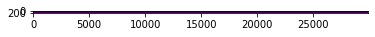

In [44]:
## Define the dataset and the training set loader
dataset=Data(people,audio,authors)
trainloader=DataLoader(dataset,2,collate_fn=lambda x: x)  #I dunno what collate_fn does, but it makes the code working

for i in trainloader:
    for j in i:
        plt.imshow(j[0][0])
        break
    break

# The Algorithm
in this first part we will be training an adversarial net that will be able to recognise the voice from a person from a voice syntecyzed from noise, so we will need two nets:
- Noise to signal
- Discriminator

Let's start from the first one

### Discriminator
it will be a RNN a audio signal as input and decides if it is from the subject or if it's artificial

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [48]:
#Add hyperparameters
class Discriminator(nn.Module):#WIP
    def __init__(self,hidden_dim):
        super(Discriminator, self).__init__()
        self.hidden_dim=hidden_dim
        #Every istant of time has 201 frequencies
        self.input=nn.Linear(201,50)
        self.lstm=nn.LSTM(50,hidden_dim)
        self.out1=nn.Linear(50,10)
        self.out2=nn.Linear(10,1)
        
    def forward(self,audio):
        hidden=(torch.zeros(1,1,len(audio)),torch.zeros(1,1,self.hidden_dim))
        guess=[]
        for freq in audio:
            x=F.relu(self.input(freq))
            x,hidden=nn.LSTM(x.view(1,1,-1),hidden)
            x=F.relu(self.out1(x))
            x=self.out2(x)
            guess.append(x)
        return np.round(np.average(guess))
        

In [49]:
test=Discriminator(50)
audio=spectrogram.view(-1,1,201)
test(audio)

TypeError: new() received an invalid combination of arguments - got (tuple, Tensor), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: ([31;1mtuple[0m, [31;1mTensor[0m)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


### Noise to signal
it will be a Recursive Neural Network (RNN) that takes noise (or audio from another person) as inputs and outputs a syntesized audio

In [ ]:
#Add hyperparameters
class Discriminator(nn.Module):#WIP
    def __init__(self):
        super(Discriminator, self).__init__()
        
        
    def forward(self,x):